# R187470B
## Nyasha D. Chiroro
### Assigment 2

### Link to the application
[https://streamlit-churn.herokuapp.com/](https://streamlit-churn.herokuapp.com/)

### Link to the assignment's GitHub repository
[https://github.com/LeCodeAlchemist/ai_assignment_2](https://github.com/LeCodeAlchemist/ai_assignment_2)

# Importing required libraries

In [3]:
import numpy as np # for linear algebra, calculating mean, standard deviation etc
import pandas as pd # load and manipulate data for One-Hot Encoding, data processing, CSV file I/O
import seaborn as sns # for creating plots
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt
import xgboost as xgb # XGBoost stuff
from sklearn.model_selection import train_test_split # split the data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer 
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws the confusion matrix

sns.set(style = 'white')

# Importing the data

In [4]:
churn_df = pd.read_csv('data/datasets_13996_18858_WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
churn_df.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

## Exploring Data, fixing some issues and  dealing with missing values

Missing data is simply a blank space or surrogate values like <b>NaN</b> that indicates that we failed to collect data for one of the features.<br>
One thing that is relatively unique about <b>XGBoost</b> is that it has default behavior for missing data. So all we have to do is identify the missing values and make sure they are set to 0.    

In [7]:
churn_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

The <code>TotalCharges</code> columns contains numerical data but it is being stored as <code>object</code>. Hence it needs to be converted to the appropriate type.

In [8]:
churn_df.TotalCharges =  pd.to_numeric(churn_df.TotalCharges, errors='coerce')


Now lets check for missing values in all columns.

In [9]:
churn_df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

As can be seen, the <code>TotalCharges</code>column has <b>11 missing values</b>. Lets take a lot at those.

In [10]:
churn_df.loc[churn_df.TotalCharges.isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


It appears that the <b>11 rows</b> with missing values for the <code>TotalCharges</code> column also have a <code>Tenure</code> of <code>0</code>. It may be the case that these customers have just joined the company which explains these conditions. Deleting these columns may result in loss of some information. A better approach may be to set the <code>TotalCharges</code> for these columns to <code>0</code>

In [11]:
churn_df[churn_df.TotalCharges == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


There are no other rows whose <code>TotalCharges</code> column is <code>0</code> which is further proof that these customers had just joined the company.

In [12]:
# Setting the TotalCharges to 0 for rows that have a missing value
churn_df.loc[churn_df.TotalCharges.isnull(), 'TotalCharges'] = 0

To verify that this worked lets find rows with <code>tenure == 0</code> since we know that those are the same people that had missing values for the <code>TotalCharges</code> column.

In [13]:
churn_df.loc[churn_df.tenure == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0.0,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0.0,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0.0,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0.0,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0.0,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0.0,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0.0,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0.0,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0.0,No


Now the missing values have been fixed.

Next we need to convert the predictor variable <b>(y)</b> which in this case is the <code>Churn</code> column from categorical into a binary numeric variable.

In [14]:
churned = len(churn_df.loc[churn_df.Churn == 'Yes'])
not_churned = len(churn_df.loc[churn_df.Churn == 'No'])

print(f'Churned: {churned}')
print(f'Did not churn: {not_churned}')

Churned: 1869
Did not churn: 5174


In [15]:
churn_df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
churn_df['Churn'].replace(to_replace='No', value=0, inplace=True)

Lets verify this worked.

In [16]:
churned = len(churn_df.loc[churn_df.Churn == 1])
not_churned = len(churn_df.loc[churn_df.Churn == 0])

print(f'Churned: {churned}')
print(f'Did not churn: {not_churned}')

Churned: 1869
Did not churn: 5174


Another issue that needs to be handled is the <code>SeniorCitizen</code> column. It is a categorical column but is being stored numerically. It may be useful to convert it into a categorical column containing <b>Yes</b> and <b>No</b> values to make the type of data explicit.

In [17]:
not_seniors = len(churn_df.loc[churn_df.SeniorCitizen == 0])
seniors = len(churn_df.loc[churn_df.SeniorCitizen == 1])

print(f'Not seniors: {not_seniors}')
print(f'Seniors: {seniors}')

Not seniors: 5901
Seniors: 1142


In [18]:
# Convert Seniors into a categorical Yes and No column.
churn_df.SeniorCitizen = churn_df.SeniorCitizen.astype(str)
churn_df.SeniorCitizen.replace(to_replace='0', value='No', inplace=True)
churn_df.SeniorCitizen.replace(to_replace='1', value='Yes', inplace=True)

# Confirm change
not_seniors = len(churn_df.loc[churn_df.SeniorCitizen == 'No'])
seniors = len(churn_df.loc[churn_df.SeniorCitizen == 'Yes'])
print(f'Not seniors: {not_seniors}')
print(f'Seniors: {seniors}')

Not seniors: 5901
Seniors: 1142


Now lets check for the unique values in each column and try to eliminate useless columns.

In [19]:
unique_values = []
for column in churn_df.columns:
    unique_values.append({column: len( churn_df[column].unique())})

In [20]:
unique_values

[{'customerID': 7043},
 {'gender': 2},
 {'SeniorCitizen': 2},
 {'Partner': 2},
 {'Dependents': 2},
 {'tenure': 73},
 {'PhoneService': 2},
 {'MultipleLines': 3},
 {'InternetService': 3},
 {'OnlineSecurity': 3},
 {'OnlineBackup': 3},
 {'DeviceProtection': 3},
 {'TechSupport': 3},
 {'StreamingTV': 3},
 {'StreamingMovies': 3},
 {'Contract': 3},
 {'PaperlessBilling': 2},
 {'PaymentMethod': 4},
 {'MonthlyCharges': 1585},
 {'TotalCharges': 6531},
 {'Churn': 2}]

Columns that have one unique value are useless for making predictions and need to be removed from the dataset. The above code above shows that there are no columns with one unique value hence per this case we dont need to drop anything. But there is something interesting with the <code>customerID</code> column.

In [21]:
len(churn_df['customerID']) ==  len(churn_df['customerID'].unique())

True

The length of the <code>customerID</code> column is the same as the number of unique values in that column meaning every value in that column is unique, which makes sense since there needs to be a unique way to identify each customer. Such columns where every value is unique are not useful for making classifications since every row is unique hence it needs to be dropped.

In [22]:
churn_df.drop(columns=['customerID'], inplace=True)
churn_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


Now that we have dealt with the missing data, we can replace all of the whitespaces in all of the columns with underscores. This is only done to be able to draw a picture of one of the <b>XGBoost</b> trees.<br>
<b>XGBoost</b> doesn't really care since we are going to <b>One Hot Encode</b> these values.

In [23]:
churn_df.replace(" ", "_", regex=True, inplace=True)
churn_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,0
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
3,Male,No,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,0
4,Female,No,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1


# Some Data Exploration

## Demographics

Let us first understand the gender, age range, patner and dependent status of the customers

### Gender distribution

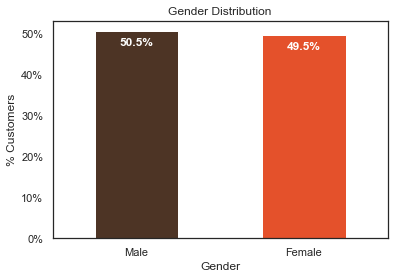

In [24]:
colors = ['#4D3425','#E4512B']

# Plot the percentage of each gender
ax = (churn_df['gender'].value_counts()*100.0 /len(churn_df)).plot(kind='bar',
                                                                   stacked = True,
                                                                   rot = 0,
                                                                   color = colors)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers')
ax.set_xlabel('Gender')
ax.set_ylabel('% Customers')
ax.set_title('Gender Distribution')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-3.5, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold')

About half of the customers in our data set are male while the other half are female

### Senior Citizens

Text(0.5, 1.0, '% of Senior Citizens')

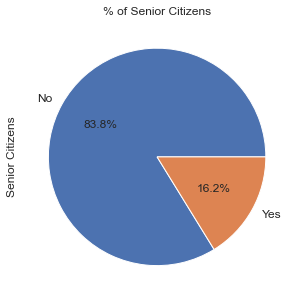

In [25]:
ax =  (churn_df.SeniorCitizen.value_counts() * 100 / len(churn_df)).plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)

There are only 16% of the customers who are senior citizens. Thus most of our customers in the data are younger people.

## Customer Account Information 

### Tenure

C:\Users\nyash\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '# of Customers by their tenure')

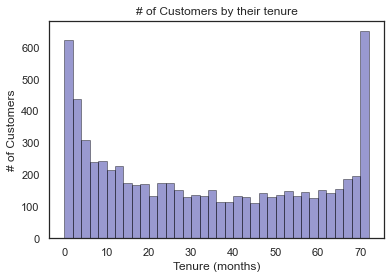

In [26]:
ax = sns.distplot(churn_df['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('# of Customers by their tenure')

After looking at the below histogram we can see that a lot of customers have been with the telecom company for just a month, while quite a many are there for about 72 months. This could be potentially because different customers have different contracts. Thus based on the contract they are into it could be more/less easier for the customers to stay/leave the telecom company.

### Contracts

Text(0.5, 1.0, '# of Customers by Contract Type')

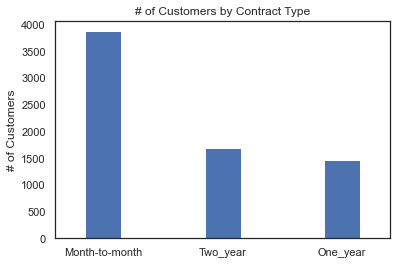

In [27]:
ax = churn_df['Contract'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('# of Customers')
ax.set_title('# of Customers by Contract Type')

As we can see from this graph most of the customers are in the month to month contract. While there are equal number of customers in the 1 year and 2 year contracts.

### Distribution of various services used by customers

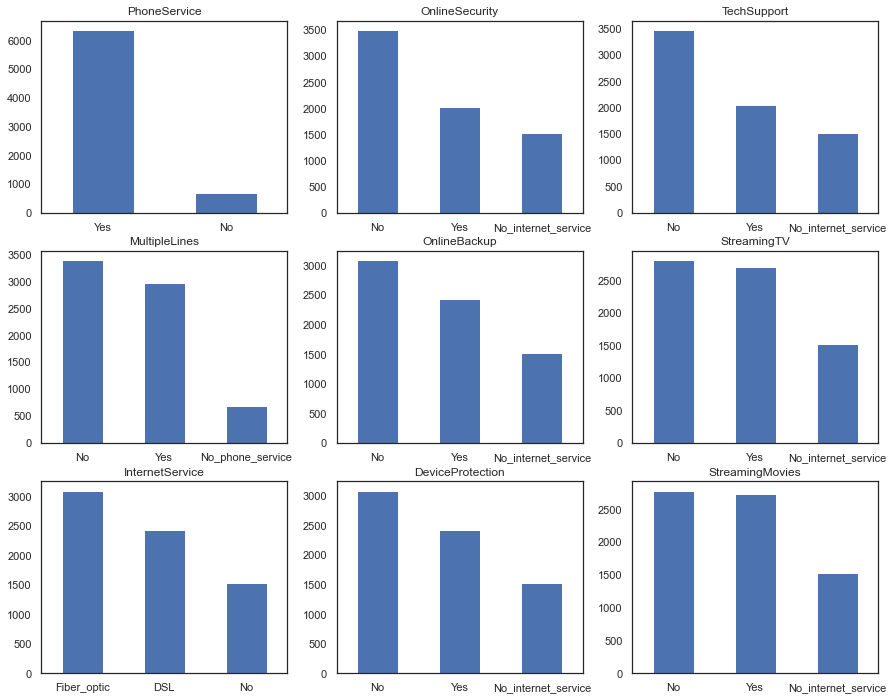

In [28]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(services):
    if i < 3:
        ax = churn_df[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = churn_df[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = churn_df[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)

### Relation between monthly and total charges

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

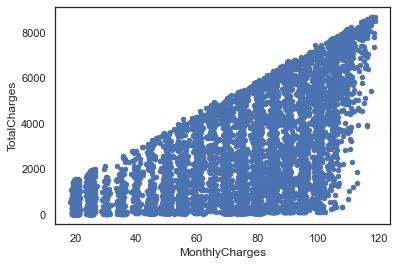

In [29]:
churn_df[['MonthlyCharges', 'TotalCharges']].plot.scatter(x = 'MonthlyCharges',
                                                              y='TotalCharges')

We will observe that the total charges increases as the monthly bill for a customer increases.

## Churn Rate

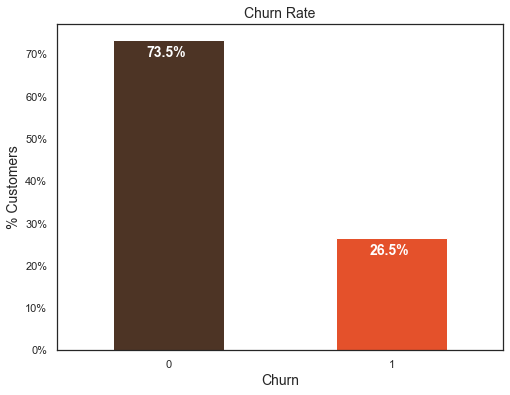

In [30]:
colors = ['#4D3425','#E4512B']
ax = (churn_df['Churn'].value_counts()*100.0 /len(churn_df)).plot(kind='bar',
                                                                      stacked = True,
                                                                      rot = 0,
                                                                      color = colors,
                                                                      figsize = (8,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('Churn',size = 14)
ax.set_title('Churn Rate', size = 14)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
            weight = 'bold',
            size = 14)

In our data, 74% of the customers do not churn. Clearly the data is skewed as we would expect a large majority of the customers to not churn. This is important to keep in mind for our modelling as skeweness could lead to a lot of false negatives. We will see in the modelling section on how to avoid skewness in the data.

## Correlations in the data

In [31]:
corr = churn_df.corr()
corr

,tenure,MonthlyCharges,TotalCharges,Churn
tenure,1.000000,0.247900,0.826178,-0.352229
MonthlyCharges,0.247900,1.000000,0.651174,0.193356
TotalCharges,0.826178,0.651174,1.000000,-0.198324
Churn,-0.352229,0.193356,-0.198324,1.000000


<AxesSubplot:>

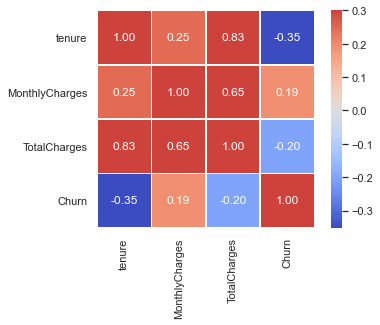

In [32]:
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values,  vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, fmt='.2f', cmap='coolwarm')

In [33]:
from dython.nominal import associations

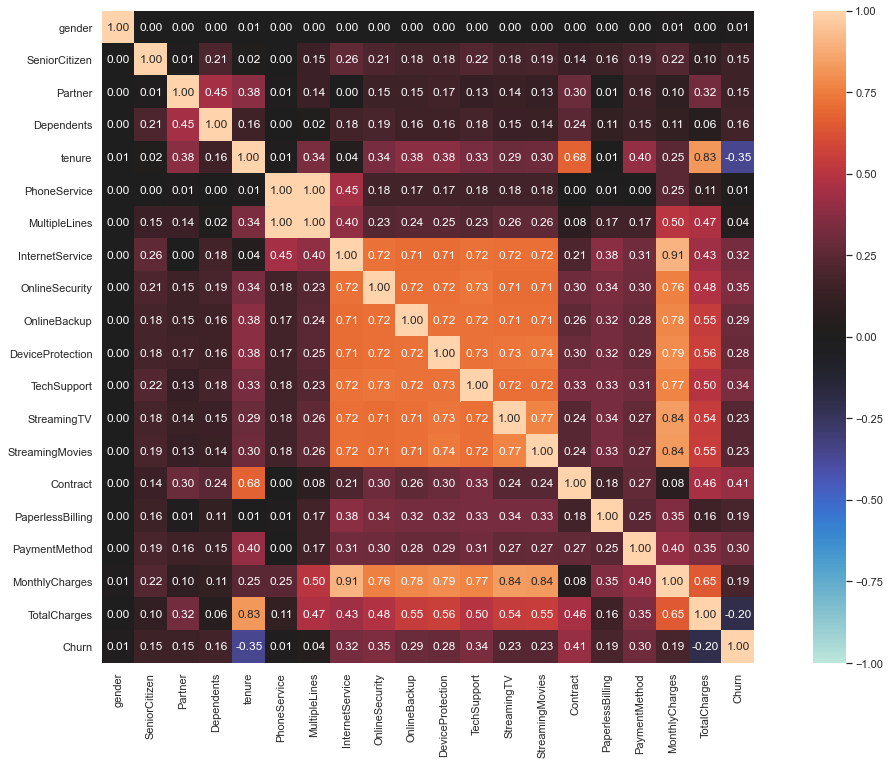

In [34]:
assc = associations(churn_df, figsize=(21, 12))

In [35]:
# corr_df = pd.DataFrame(assc['corr'])
# corr_df

### Selecting relevant features from the correlation data

In [36]:
selected_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract',  'MultipleLines','PaperlessBilling', 'PaymentMethod','TotalCharges', 'MonthlyCharges']

To select features I manually inspected the <b>pairwise correlations</b> and <b>correlations with the dependent variable</b>. For <b>pairwise corrections</b> I was looking at features that have a <code>correlation > 0.5</code> then between the 2 I picked the column with a greater correlation with the dependent variable <code>Churn</code>. If a feature did not have a correlation greater than <code>0.5</code> with any other feature I was picking it. 

# Formatting the data for the model: Splitting the data into dependent and independent variables and One Hot Encoding

We want to predict <code>Churn</code> hence that will be our <b>y</b>.<br>
All the other columns are the features and will be our <b>X</b>.

In [37]:
# X = churn_df.drop(columns=['Churn']).copy()
X = churn_df.loc[:, selected_features].copy()
X.head()

,gender,SeniorCitizen,Partner,Dependents,Contract,MultipleLines,PaperlessBilling,PaymentMethod,TotalCharges,MonthlyCharges
0,Female,No,Yes,No,Month-to-month,No_phone_service,Yes,Electronic_check,29.85,29.85
1,Male,No,No,No,One_year,No,No,Mailed_check,1889.50,56.95
2,Male,No,No,No,Month-to-month,No,Yes,Mailed_check,108.15,53.85
3,Male,No,No,No,One_year,No_phone_service,No,Bank_transfer_(automatic),1840.75,42.30
4,Female,No,No,No,Month-to-month,No,Yes,Electronic_check,151.65,70.70


In [38]:
y = churn_df.Churn.copy()
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In the code above we are using the <code>copy()</code> to copy the data by value not the default behavior of pandas to copy the data by reference. <br>
Using <code>copy()</code> ensures that the original data is not modified when we modify <code>X</code> and <code>y</code>.

### One Hot Encoding

Some variables in <b>X</b> are categorical and need to be encoded into numbers.<br>
<ul>
    <li>gender - Category</li>
    <li>SeniorCitizen - Category</li>
    <li>Partner - Category</li>
    <li>Dependants - Category</li>
    <li>tenure - Integer</li>
    <li>PhoneService - Category</li>
    <li>MultipleLines - Category</li>
    <li>InternetService - Category</li>
    <li>OnlineSecurity - Category</li>
    <li>OnlineBackup - Category</li>
    <li>DeviceProtection - Category</li>
    <li>TechSupport - Category</li>
    <li>StreamingTV - Category</li>
    <li>StreamingMovies - Category</li>
    <li>Contract - Category</li>
    <li>PaperlessBilling - Category</li>
    <li>PaymentMethod - Category</li>
    <li>MonthlyCharges - Float</li>
    <li>TotalCharges - Float</li>
</ul>

In [39]:
X.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
Contract             object
MultipleLines        object
PaperlessBilling     object
PaymentMethod        object
TotalCharges        float64
MonthlyCharges      float64
dtype: object

In [40]:
# X_encoded = pd.get_dummies(X, columns=['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
#                                         'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
#                                         'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'])

categories = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MultipleLines']
X_encoded = pd.get_dummies(X, columns=categories)

# from sklearn.compose import ColumnTransformer

# categories = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MultipleLines']
# transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categories)], remainder='passthrough')
# X_encoded = transformer.fit_transform(X)
# type(X_encoded)

In [41]:
X_encoded

,TotalCharges,MonthlyCharges,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check,MultipleLines_No,MultipleLines_No_phone_service,MultipleLines_Yes
0,29.85,29.85,1,0,1,0,0,1,1,0,...,0,0,1,0,0,1,0,0,1,0
1,1889.50,56.95,0,1,1,0,1,0,1,0,...,0,1,0,0,0,0,1,1,0,0
2,108.15,53.85,0,1,1,0,1,0,1,0,...,0,0,1,0,0,0,1,1,0,0
3,1840.75,42.30,0,1,1,0,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
4,151.65,70.70,1,0,1,0,1,0,1,0,...,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1990.50,84.80,0,1,1,0,0,1,0,1,...,0,0,1,0,0,0,1,0,0,1
7039,7362.90,103.20,1,0,1,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
7040,346.45,29.60,1,0,1,0,0,1,0,1,...,0,0,1,0,0,1,0,0,1,0
7041,306.60,74.40,0,1,0,1,0,1,1,0,...,0,0,1,0,0,0,1,0,0,1


In [42]:
y.unique()

array([0, 1], dtype=int64)

# Building An Initial XGBoost Model

Now the data is correctly formatted for making an <b>XGBoost</b> model. Lets split the data into training and test sets

### Checking for data imbalance

In [43]:
percentage_left = sum(y) / len(y)
percentage_left

0.2653698707936959

We can see that only <b>27%</b> of the people in the dataset left the company. Because of this when we split into
training and testing, we will split using stratification in order to maintain the same percentage of people who left the companhy in both the <b>training</b> set and the <b>test</b> set.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

Lets verify that the stratification process actually worked and we have the same amount of people who left the company in both the training set and the test set.

In [45]:
sum(y_train)/len(y_train)

0.2654297614539947

In [46]:
sum(y_test)/len(y_test)

0.26519023282226006

Both <code>y_test</code> and <code>y_train</code> have approximately <b>27%</b> of customers who left hence <code>stratify</code> worked.

### Evaluation functions

In [47]:
import scikitplot as skplt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_fscore_support

In [48]:
def print_evaluation_metric (y_true, y_pred):
    #
    # Function to print out the model evaluation metrics
    # Args:
    #   y_true: array of y true label
    #   y_pred: array of y predicted class
    #
    # Return:
    #   None
    #
    precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred)
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F-score: {}".format(fscore))
    print("Support: {}".format(support))
    return 

def plot_roc_curve (y_true, y_prob, filename="img.png", dpi = 200):
    #
    # Function to plot the ROC curve by computing fpr and tpr as well as save the plot to file
    # Args:
    #   y_true: array of y true label
    #   y_prob: the output of y probability prediction (outcome for predict_proba() function)
    #   filename: the name of the file to be saved
    #   dpi: the resolution of the figure
    # Return:
    #   None
    #
    fpr, tpr, threshold = roc_curve(y_true, y_prob[:, 1])
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.plot(fpr, tpr, 'b')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    fig.savefig(filename, dpi = dpi)
    return

### Defining and training the initial model

In [49]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, seed=42)
clf_xgb.fit(X_train,
              y_train,
              verbose=True,
              early_stopping_rounds=30,
              eval_metric='aucpr',
              eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.63033
[1]	validation_0-aucpr:0.63499
[2]	validation_0-aucpr:0.63401
[3]	validation_0-aucpr:0.63794
[4]	validation_0-aucpr:0.63777
[5]	validation_0-aucpr:0.63750
[6]	validation_0-aucpr:0.63376
[7]	validation_0-aucpr:0.63539
[8]	validation_0-aucpr:0.63398
[9]	validation_0-aucpr:0.63417
[10]	validation_0-aucpr:0.63473
[11]	validation_0-aucpr:0.63373
[12]	validation_0-aucpr:0.63189
[13]	validation_0-aucpr:0.63059
[14]	validation_0-aucpr:0.63403
[15]	validation_0-aucpr:0.63357
[16]	validation_0-aucpr:0.62762
[17]	validation_0-aucpr:0.62721
[18]	validation_0-aucpr:0.62624
[19]	validation_0-aucpr:0.62568
[20]	validation_0-aucpr:0.62955
[21]	validation_0-aucpr:0.62918
[22]	validation_0-aucpr:0.62581
[23]	validation_0-aucpr:0.62652
[24]	validation_0-aucpr:0.62612
[25]	validation_0-aucpr:0.62614
[26]	validation_0-aucpr:0.62521
[27]	validation_0-aucpr:0.62512
[28]	validation_0-aucpr:0.62315
[29]	validation_0-aucpr:0.62275
[30]	validation_0-aucpr:0.62255
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Ok, we've built the <b>XGBoost</b> model for classification. Lets see how it performs on the <b>Testing Dataset</b> by running the <b>Testing Dataset</b> down the model and drawing a <b>Confusion Matrix</b>.

C:\Users\nyash\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


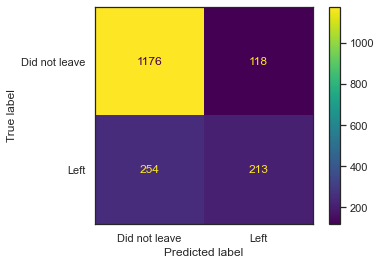

In [50]:
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                     display_labels=['Did not leave', 'Left'])

In the confusion matrix, we can see that of the <b>1294</b> people <b>who did not leave</b>, <b>1176 (90%)</b> were correctly classified. And of the <b>467</b> people that <b>left the company</b>, <b>213 (45%)</b> were correctly classified. Hence there XGBoost model was not awesome. Part of the problem is that our data is imbalanced, which we saw earlier and we see this in confusion matrix with the top row showing <b>1294</b> people who <b> did not leave </b> and the bottom row showing <b>467</b> people <b>did leave</b>. Because people leaving the costs the company a lot of money, we would like to capture more of the people that left. The good news is that <b>XGBoost</b> has a parameter <code>scale_pos_weight</code>, that helps with imbalanced data. So lets try to improve predictions using <b>Cross Validation</b> to optimize the parameters.

In [51]:
y_pred =  clf_xgb.predict(X_test)

In [52]:
y_prob =  clf_xgb.predict_proba(X_test)

In [53]:
print_evaluation_metric(y_test, y_pred)

Precision: [0.82237762 0.64350453]
Recall: [0.90880989 0.45610278]
F-score: [0.86343612 0.53383459]
Support: [1294  467]


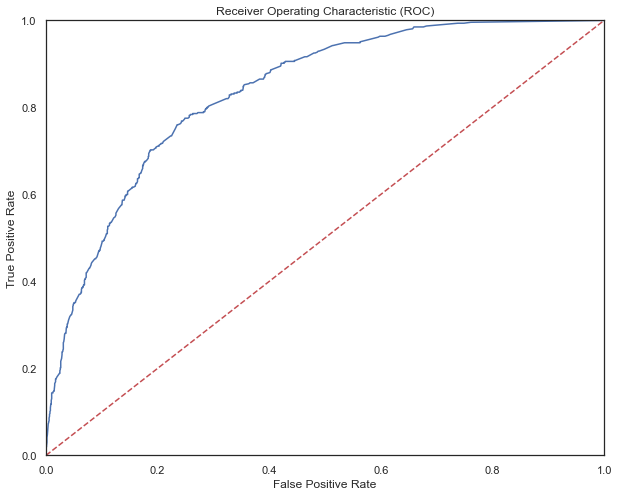

In [54]:
plot_roc_curve(y_test, y_prob, filename="ROC1.png", dpi=20)

## Optimise Paramaters using Cross Validation and GridSearchCV()

<b>XGBoost</b> has a lot of parameters that we have to manually configure and are nor determined by <b>XGBoost</b> itself, including <code>max_depth</code>, the maximum tree depth, <code>learning_rate</code>, or "eta", <code>gamma</code>, the parameter that encourages pruning, and <code>reg_lambda</code>, the regularization parameter lambda. So lets try to find the optimal values for these parameters in hopes that we can improve the accuracy with the <b>Testing Dataset</b><br>

We have a lot of parameters hence testing them one by one would be very time consuming. Luckily we can use <code>GridSearchCV</code>. With this we can specify a list of potential values for the hyperparameters and <code>GridSearchCV</code> test all possible parameter combinations and returns the results.

In [55]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 0.5, 1.0, 10.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 20.0],
    'scale_pos_weight': [1, 3, 5]
}

estimator = xgb.XGBClassifier(objective = 'binary:logistic')

In [56]:
cv_clf = GridSearchCV(estimator,
                      param_grid=param_grid,
                      scoring='roc_auc', # see see sklearn model evaluation docs
                      verbose=2, # Note: if you want to see what Gridsearch is doing set to 2, otherwise 0
                      n_jobs=10,
                      cv=5)

In [57]:
cv_clf.fit(X_train,
           y_train,
           early_stopping_rounds=10,
           eval_metric='auc',
           eval_set=[(X_test, y_test)],
           verbose=True)

Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   16.6s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   31.8s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 993 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 1438 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 1965 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done 2572 tasks      | elapsed:  4.4min
[Parallel(n_jobs=10)]: Done 3261 tasks      | elapsed:  5.6min


[0]	validation_0-auc:0.81163
[1]	validation_0-auc:0.81275
[2]	validation_0-auc:0.82272
[3]	validation_0-auc:0.82244
[4]	validation_0-auc:0.82719
[5]	validation_0-auc:0.82745
[6]	validation_0-auc:0.82944
[7]	validation_0-auc:0.82856
[8]	validation_0-auc:0.82882
[9]	validation_0-auc:0.83062
[10]	validation_0-auc:0.83102
[11]	validation_0-auc:0.83005
[12]	validation_0-auc:0.83242
[13]	validation_0-auc:0.83188
[14]	validation_0-auc:0.83242
[15]	validation_0-auc:0.83298
[16]	validation_0-auc:0.83356
[17]	validation_0-auc:0.83418
[18]	validation_0-auc:0.83459
[19]	validation_0-auc:0.83576
[20]	validation_0-auc:0.83663


[Parallel(n_jobs=10)]: Done 3375 out of 3375 | elapsed:  5.8min finished
C:\Users\nyash\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-auc:0.83697
[22]	validation_0-auc:0.83678
[23]	validation_0-auc:0.83683
[24]	validation_0-auc:0.83732
[25]	validation_0-auc:0.83771
[26]	validation_0-auc:0.83769
[27]	validation_0-auc:0.83814
[28]	validation_0-auc:0.83879
[29]	validation_0-auc:0.83870
[30]	validation_0-auc:0.83922
[31]	validation_0-auc:0.84001
[32]	validation_0-auc:0.84067
[33]	validation_0-auc:0.84072
[34]	validation_0-auc:0.84111
[35]	validation_0-auc:0.84150
[36]	validation_0-auc:0.84198
[37]	validation_0-auc:0.84213
[38]	validation_0-auc:0.84275
[39]	validation_0-auc:0.84289
[40]	validation_0-auc:0.84252
[41]	validation_0-auc:0.84281
[42]	validation_0-auc:0.84251
[43]	validation_0-auc:0.84255
[44]	validation_0-auc:0.84286
[45]	validation_0-auc:0.84279
[46]	validation_0-auc:0.84292
[47]	validation_0-auc:0.84305
[48]	validation_0-auc:0.84308
[49]	validation_0-auc:0.84295
[50]	validation_0-auc:0.84293
[51]	validation_0-auc:0.84279
[52]	validation_0-auc:0.84270
[53]	validation_0-auc:0.84283
[54]	valid

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [58]:
best_score = cv_clf.best_score_
best_params = cv_clf.best_params_
print(f'Best score: {best_score}')
print('Best params: ')
for param_name in sorted(best_params.keys()):
    print(f'{param_name}: {best_params[param_name]}')

Best score: 0.841828082170242
Best params: 
gamma: 0
learning_rate: 0.1
max_depth: 3
reg_lambda: 10.0
scale_pos_weight: 5


So after testing all possible combinations of potential parameter values with <b>Cross Validation</b>, we that we should set <code>gamma=0.0</code>, <code>learn_rate=0.1</code>, <code>max_depth=3</code>, <code>reg_lambda=10.0</code> and <code>scale_pos_weight=5</code>

## Building, Evaluating, Drawing, and Interpreting the Optimized XGBoost Model.

In [59]:
best_xgb = xgb.XGBClassifier(seed=42,
                           objective='binary:logistic',
                           gamma=0.0,
                           learn_rate=0.1,
                           max_depth=3,
                           reg_lambda=10.0,
                           scale_pos_weight=5
                           )
best_xgb.fit(X_train,
           y_train,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[18:38:01] WARNING: ..\src\learner.cc:573: 
Parameters: { "learn_rate" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.55226
[1]	validation_0-aucpr:0.57241
[2]	validation_0-aucpr:0.58370
[3]	validation_0-aucpr:0.58853
[4]	validation_0-aucpr:0.58922
[5]	validation_0-aucpr:0.60414
[6]	validation_0-aucpr:0.60900
[7]	validation_0-aucpr:0.61678
[8]	validation_0-aucpr:0.61447
[9]	validation_0-aucpr:0.61843
[10]	validation_0-aucpr:0.61778
[11]	validation_0-aucpr:0.61997
[12]	validation_0-aucpr:0.63827
[13]	validation_0-aucpr:0.64199
[14]	validation_0-aucpr:0.64114
[15]	validation_0-aucpr:0.64093
[16]	validation_0-aucpr:0.63765
[17]	validation_0-aucpr:0.63696
[18]	validation_0-aucpr:0.64111
[19]	validation_0-aucpr:0.64148
[20]	validation_0-aucpr:0.64156
[21]	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learn_rate=0.1, learning_rate=0.300000012, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=42, reg_alpha=0,
              reg_lambda=10.0, scale_pos_weight=5, seed=42, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Now lets draw another confusion matrix using the optimised <b>XGBoost</b> to see if it performs any better.

C:\Users\nyash\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


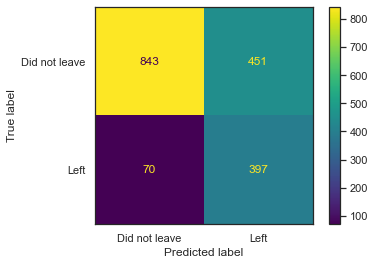

In [60]:
plot_confusion_matrix(best_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=['Did not leave', 'Left'])

We see that the optimized <b>XGBoost</b> model is a lot better at identifying people that <b>left the company</b>. Of the <b>467</b> people that left the company, <b>397 (85%)</b> were correctly identified. Before the optimisation, we only correctly identified <b>213 (45%)</b>. However the improvement was at the expense of people who did not leave. Before the optimisation we correctly identified <b>1176 (90%)</b> people that did not leave. Now we correctly classified <b>843 (65%)</b>. That said this may be better since we are more interested in people who might leave the company.

In [61]:
y_pred =  best_xgb.predict(X_test)

In [62]:
y_prob =  best_xgb.predict_proba(X_test)

In [63]:
print_evaluation_metric(y_test, y_pred)

Precision: [0.92332968 0.46816038]
Recall: [0.65146832 0.85010707]
F-score: [0.76393294 0.60380228]
Support: [1294  467]


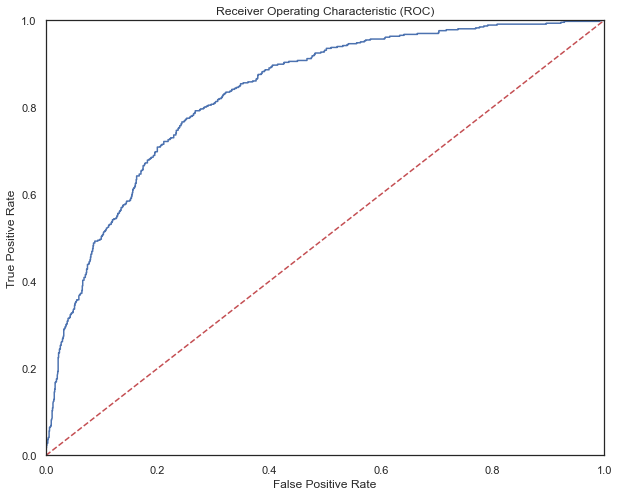

In [64]:
plot_roc_curve(y_test, y_prob, filename="ROC2.png", dpi=20)

### A Visual of the XGBoost Tree

C:\Users\nyash\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:38:03] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample", "learn_rate" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:38:03] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Contract_Month-to-month': 1, 'MonthlyCharges': 7, 'Contract_One_year': 2, 'gender_Female': 1, 'TotalCharges': 5, 'Dependents_No': 1, 'PaymentMethod_Electronic_check': 1}
gain:  {'Contract_Month-to-month': 2073.73193, 'MonthlyCharges': 86.62023222857144, 'Contract_One_year': 58.420160300000006, 'gender_Female': 18.9935722, 'TotalCharges': 55.29686774, 'Dependents_No': 10.5209274, 'PaymentMe

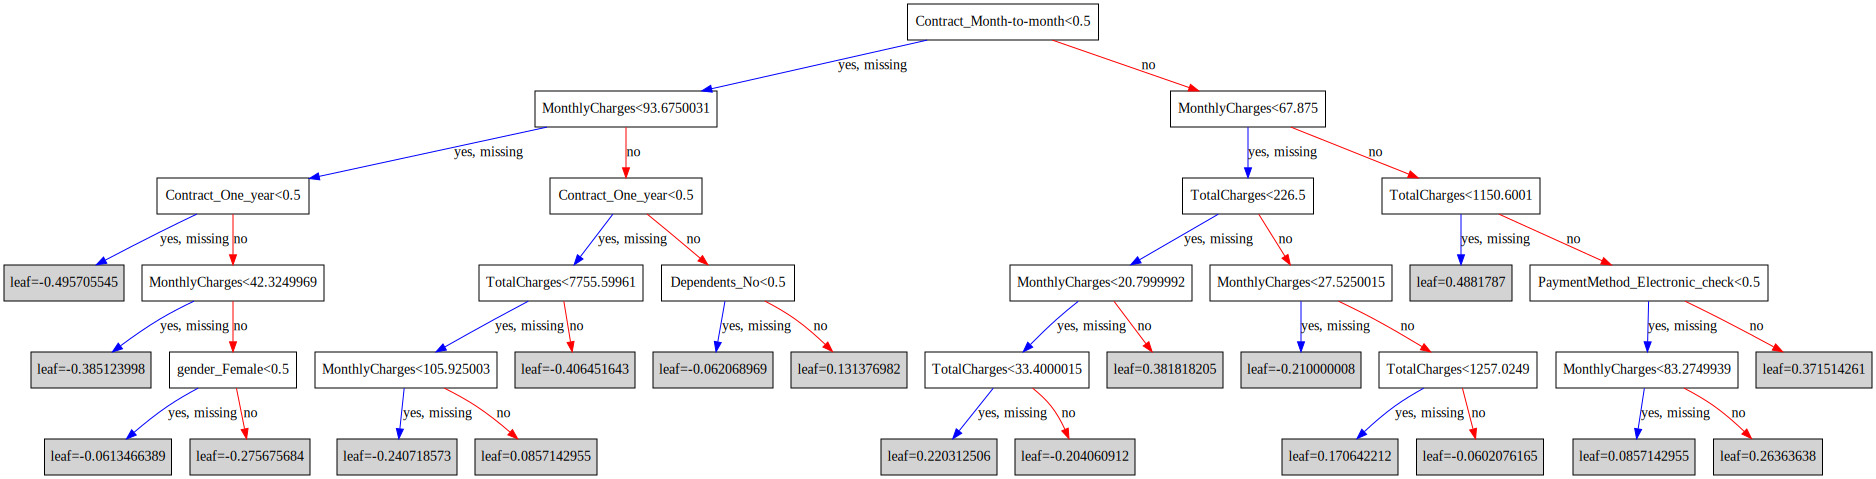

In [65]:
## If we want to get information like gain and cover etc, at each node in the first tree, we just build the first
## tree, otherwise we we'll get the average of all the trees.
best_xgb = xgb.XGBClassifier(seed=42,
                           objective='binary:logistic',
                           gamma=10.0,
                           learn_rate=0.1,
                           max_depth=5,
                           reg_lambda=10.0,
                           scale_pos_weight=5,
                           subsample=0.9,
                           colsample=0.5,
                           n_estimators=1 ## We set this to 1 so we can get gain, cover etc
                           )

best_xgb.fit(X_train,
           y_train)

## now print out the weight, gain, cover etc for the tree
## weight = number of times a feature is used in a branch or root across all trees
## gain = the average coverage across all splits that the feature is used in
## cover = the average coverage across all splits a feature is used in
## total_gain = the total gain across all splits the feature is used in
## total_cover =  the total coverage across all splits the feature is used in
## Note: since we only built one tree, gain=total_gain and cover=total_cover

bst = best_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {
    'shape': 'box',
    'style': 'filled rounded',
    'fillcolor': '#78cbe'
}

leaf_params = {
    'shape': 'box',
    'style': 'filled',
    'fillcover': '#e48038'
}

## Note: num_trees is not the number of trees to plot, but the specific tree you want to plot
## The default value is 0, but im setting it to show it in action since it is counter-intuitive
## xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10")

xgb.to_graphviz(best_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params, 
              leaf_node_params=leaf_params)

## If you want to save the figure
# graph_data = xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10", condition_node_params=node_params, 
#                leaf_node_params=leaf_node_params)
# graph_data.view(filename='xgboost_tree_customer_churn') ## save as PDF

### Saving the model

In [66]:
best_xgb.save_model('xgb_customer_churn.json')